In [95]:
#Import Tools
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
import requests
import openpyxl

In [96]:
# Gives adjacency dictionary (not mine)
edge_dict={}
def create_edge_dict(graph):
    for i, n in G.adjacency():
        # print("i is",i)
        # print("n is",n)
        edge_dict[i] = list(n)
    return edge_dict

# Gives duplicate items in a list (not mine)
def list_duplicates(seq):
  seen = set()
  seen_add = seen.add
  # adds all elements it doesn't know yet to seen and all other to seen_twice
  seen_twice = set( x for x in seq if x in seen or seen_add(x) )
  # turn the set into a list (as requested)
  return list( seen_twice )


#(https://www.geeksforgeeks.org/python-merge-two-lists-into-list-of-tuples/)
def merge(list1, list2):
      
    merged_list = []
    for i in range(max((len(list1), len(list2)))):
  
        while True:
            try:
                tup = (list1[i], list2[i])
            except IndexError:
                if len(list1) > len(list2):
                    list2.append('')
                    tup = (list1[i], list2[i])
                elif len(list1) < len(list2):
                    list1.append('')
                    tup = (list1[i], list2[i])
                continue
  
            merged_list.append(tup)
            break
    return merged_list


# function to check whether the list is empty or not
def is_list_empty(list):
    # checking the length
    if len(list) == 0:
        # returning true as length is 0
        return True
    # returning false as length is greater than 0
    return False

In [97]:
# #retrieve data regarding vacant spaces
from openpyxl import load_workbook
workbook = load_workbook(filename="Node_Information_TU.xlsx")
workbook.sheetnames
sheet1 = workbook.worksheets[0]
sheet2 = workbook.worksheets[1]

# #create dictionary based on excel worksheet
vacant_spaces={}
for value in sheet1.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
        vacant_spaces[value[0]]={}
        vacant_spaces[value[0]]["location"]=value[1]
        vacant_spaces[value[0]]["tag"]=value[6]
        vacant_spaces[value[0]]["building"]=value[3]
        vacant_spaces[value[0]]["size_real"]=int(value[2])
        vacant_spaces[value[0]]["loc_building"]=value[4]
        vacant_spaces[value[0]]["orientation"]=value[5]
        vacant_spaces[value[0]]["node_type"]=value[7]

#interpret data
#Rules:
#structure (roof:1,ground:3,outside:3,basement:3,intermediate:2)
#solar (roof:3,
#       basement:1
#       ground & S,SW,SE:3,
#       ground $ E,W:2
#       ground $ N,NE,NW:1
#       outside & S,SW,SE:3,
#       outside $ E,W:2
#       outside $ N,NE,NW:1
#       intermediate & S,SW,SE:3,
#       intermediate & E,W:2
#       intermediate & N,NE,NW:1
#size (0-100 size:1)
#     (101-500 size:2)
#     (500-... size:3)

for space in vacant_spaces:
    if vacant_spaces[space]["loc_building"]=="roof":
        vacant_spaces[space]["structure"]=1
        vacant_spaces[space]["solar"]=3
    if vacant_spaces[space]["loc_building"]=="basement":
        vacant_spaces[space]["structure"]=3
        vacant_spaces[space]["solar"]=1
    if (vacant_spaces[space]["loc_building"]=="ground") and (((vacant_spaces[space]["orientation"])=="S") or ((vacant_spaces[space]["orientation"])=="SE") or ((vacant_spaces[space]["orientation"])=="SW")):
        vacant_spaces[space]["solar"]=3
        vacant_spaces[space]["structure"]=3
    if (vacant_spaces[space]["loc_building"]=="ground") and (((vacant_spaces[space]["orientation"])=="N") or ((vacant_spaces[space]["orientation"])=="NE") or ((vacant_spaces[space]["orientation"])=="NW")):
        vacant_spaces[space]["solar"]=1
        vacant_spaces[space]["structure"]=3
    if (vacant_spaces[space]["loc_building"]=="ground") and (((vacant_spaces[space]["orientation"])=="E") or ((vacant_spaces[space]["orientation"])=="W")):
        vacant_spaces[space]["solar"]=2
        vacant_spaces[space]["structure"]=3
    if (vacant_spaces[space]["loc_building"]=="intermediate") and (((vacant_spaces[space]["orientation"])=="S") or ((vacant_spaces[space]["orientation"])=="SE") or ((vacant_spaces[space]["orientation"])=="SW")):
        vacant_spaces[space]["solar"]=3
        vacant_spaces[space]["structure"]=2
    if (vacant_spaces[space]["loc_building"]=="intermediate") and (((vacant_spaces[space]["orientation"])=="N") or ((vacant_spaces[space]["orientation"])=="NE") or ((vacant_spaces[space]["orientation"])=="NW")):
        vacant_spaces[space]["solar"]=1
        vacant_spaces[space]["structure"]=2
    if (vacant_spaces[space]["loc_building"]=="intermediate") and (((vacant_spaces[space]["orientation"])=="E") or ((vacant_spaces[space]["orientation"])=="W")):
        vacant_spaces[space]["solar"]=2
        vacant_spaces[space]["structure"]=2
    if (vacant_spaces[space]["loc_building"]=="outside") and (((vacant_spaces[space]["orientation"])=="S") or ((vacant_spaces[space]["orientation"])=="SE") or ((vacant_spaces[space]["orientation"])=="SW")):
        vacant_spaces[space]["solar"]=3
        vacant_spaces[space]["structure"]=3
    if (vacant_spaces[space]["loc_building"]=="outside") and (((vacant_spaces[space]["orientation"])=="N") or ((vacant_spaces[space]["orientation"])=="NE") or ((vacant_spaces[space]["orientation"])=="NW")):
        vacant_spaces[space]["solar"]=1
        vacant_spaces[space]["structure"]=3
    if (vacant_spaces[space]["loc_building"]=="outside") and (((vacant_spaces[space]["orientation"])=="E") or ((vacant_spaces[space]["orientation"])=="W")):
        vacant_spaces[space]["solar"]=2
        vacant_spaces[space]["structure"]=3

#interpret size based on predefined ranges
for space in vacant_spaces:
    if vacant_spaces[space]["size_real"]<=100:
        vacant_spaces[space]["size"]=1
    if (vacant_spaces[space]["size_real"]>100) and (vacant_spaces[space]["size_real"]<=500) :
        vacant_spaces[space]["size"]=2
    if (vacant_spaces[space]["size_real"]>500):
        vacant_spaces[space]["size"]=3
    
#remove orientation,loc_building,size_real
for space in vacant_spaces:
    vacant_spaces[space].pop("orientation")
    vacant_spaces[space].pop("size_real")
    vacant_spaces[space].pop("loc_building")   
     
#retrieve waste sources
#create dictionary based on excel worksheet
wastes={}
for value in sheet2.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
            wastes[value[0]]={}
            wastes[value[0]]["location"]=value[1]
            wastes[value[0]]["tag"]=value[5]
            wastes[value[0]]["type"]=value[3]
# print(wastes)

In [98]:
#retrieve connections within radius=x
url = "https://raw.githubusercontent.com/erengozdeanil/UF-DecisionMaker/main/Edges2.txt"
resp = requests.get(url)
edges = json.loads(resp.text)
#converts nested lists into a list of tuples
edge_coordinates100 = [tuple(i) for i in edges]


#retrieve connections between vacant spaces within radius=x
url1="https://raw.githubusercontent.com/erengozdeanil/UF-DecisionMaker/main/Edges_vacant200.txt"
resp1 = requests.get(url1)
edges1 = json.loads(resp1.text)
#converts nested lists into a list of tuples
nearby_space_coordinates = [tuple(i) for i in edges1]

#retrieve connections within radius=3x

#combine wastes and vacant_spaces
combined_dict=vacant_spaces.copy()
combined_dict.update(wastes)
# print(edge_coordinates100)

#replace coordinates with identifiers
# FOR NEARBY WASTE100
nearby_waste100=[]
for couple in edge_coordinates100:
    for space in vacant_spaces:
        for waste in wastes:
            if couple[0]==vacant_spaces[space]["location"]:
                if couple[1]==wastes[waste]["location"]:
                    edge_tuple=(space,waste)
                    nearby_waste100.append(edge_tuple)




In [99]:
# FOR NEARBY SPACE
start1=[]
end1=[]
nearby_space100=[]
for couple in nearby_space_coordinates:
    for space1 in vacant_spaces:
        for space2 in combined_dict:
            if couple[0]==vacant_spaces[space1]["location"]:
                if couple[1]==combined_dict[space2]["location"]:
                    new_tuple=(space1,space2) 
                    reverse=(space2,space1) 
                    if reverse not in nearby_space100:
                        nearby_space100.append(new_tuple)

In [100]:
for waste in wastes:
    for couple in nearby_waste100:
        if wastes[waste]["type"]=="None":
            if waste == couple[0]:
                nearby_waste100.remove(couple)
                print(waste,couple,"removed1")
for waste in wastes:
    for couple in nearby_waste100:
        if wastes[waste]["type"]=="None":
            if waste == couple[1]:
                nearby_waste100.remove(couple)
                print(waste,couple,"removed2")

for couple in nearby_waste100:
    if "WO71" in couple:
        nearby_waste100.remove(couple)

WO15 ('V1', 'WO15') removed2
WO15 ('V2', 'WO15') removed2
WO15 ('V13', 'WO15') removed2
WO15 ('V23', 'WO15') removed2
WO15 ('V54', 'WO15') removed2
WO15 ('V67', 'WO15') removed2
WO15 ('V75', 'WO15') removed2
WO15 ('V83', 'WO15') removed2
WO15 ('V106', 'WO15') removed2
WO15 ('V130', 'WO15') removed2
WO25 ('V1', 'WO25') removed2
WO25 ('V8', 'WO25') removed2
WO25 ('V13', 'WO25') removed2
WO25 ('V14', 'WO25') removed2
WO25 ('V25', 'WO25') removed2
WO25 ('V79', 'WO25') removed2
WO25 ('V121', 'WO25') removed2
WO25 ('V124', 'WO25') removed2
WO25 ('V145', 'WO25') removed2
WO32 ('V2', 'WO32') removed2
WO32 ('V23', 'WO32') removed2
WO32 ('V78', 'WO32') removed2
WO32 ('V106', 'WO32') removed2
WO32 ('V112', 'WO32') removed2
WO32 ('V130', 'WO32') removed2
WO46 ('V2', 'WO46') removed2
WO46 ('V13', 'WO46') removed2
WO46 ('V23', 'WO46') removed2
WO46 ('V78', 'WO46') removed2
WO46 ('V106', 'WO46') removed2
WO46 ('V112', 'WO46') removed2
WO46 ('V121', 'WO46') removed2
WO46 ('V130', 'WO46') removed2
WO47

In [101]:
workbook = load_workbook(filename="Node_Information_TU.xlsx")
workbook.sheetnames
sheet1 = workbook.worksheets[0]
sheet2 = workbook.worksheets[1]
wastes={}
for value in sheet2.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
        if value[3]!="None":
            wastes[value[0]]={}
            wastes[value[0]]["location"]=value[1]
            wastes[value[0]]["source"]=value[2]
            wastes[value[0]]["tag"]=value[5]
            wastes[value[0]]["type"]=value[3]
            wastes[value[0]]["quantity"]=int(value[4])
            wastes[value[0]]["node_type"]="waste"


#assign ranges to quantities
for waste in wastes:
    if wastes[waste]["type"]=="W1":
        if wastes[waste]["quantity"]<= 91852:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>91852) and (wastes[waste]["quantity"]<=459261):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>459261:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W2":
        if wastes[waste]["quantity"]<= 25000:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>25000) and (wastes[waste]["quantity"]<=125000):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>125000:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W3":
        if wastes[waste]["quantity"]<= 5906:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>5906) and (wastes[waste]["quantity"]<=29531):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>29531:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W4":
        if wastes[waste]["quantity"]<= 14100:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>14100) and (wastes[waste]["quantity"]<=70500):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>70500:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W5":
        if wastes[waste]["quantity"]<= 7937:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>7937) and (wastes[waste]["quantity"]<=39684):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>39684:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W6":
        if wastes[waste]["quantity"]<= 187612:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>187612) and (wastes[waste]["quantity"]<=938060):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>938060:
            wastes[waste]["size"]=3
    if wastes[waste]["type"]=="W7":
        if wastes[waste]["quantity"]<= 100000:
            wastes[waste]["size"]=1
        if (wastes[waste]["quantity"]>100000) and (wastes[waste]["quantity"]<=500000):
            wastes[waste]["size"]=2
        if wastes[waste]["quantity"]>500000:
            wastes[waste]["size"]=3
# #remove quantity
for waste in wastes:
    wastes[waste].pop("quantity")

In [102]:
# #Create dummy data
# # 8:{"location":(0,0),"tag":"WO6","building":"BK","size":2,"type":"W2"}
# # 1:{"location":(0,0),"tag":"V1","building":"BK","size":3,"structure":3,"solar":1}

# vacant_spaces = {
# "V1":{"location":(0,1),"tag":"V1","building":"BK","size":1,"structure":3,"solar":1, "node_type":"vacant"}, 
# "V2":{"location":(10,2),"tag":"V2","building":"BK","size":1,"structure":3,"solar":2, "node_type":"vacant"},
# "V3":{"location":(2,7),"tag":"V3","building":"BK","size":1,"structure":3,"solar":2, "node_type":"vacant"},
# "V4":{"location":(4,8),"tag":"V4","building":"BK","size":1,"structure":1,"solar":3, "node_type":"vacant"},
# "V5":{"location":(2,3),"tag":"V5","building":"BK","size":1,"structure":1,"solar":3, "node_type":"vacant"},
# "V6":{"location":(4,4),"tag":"V6","building":"BK","size":1,"structure":2,"solar":1, "node_type":"vacant"}}

# wastes = {
# "WO1":{"location":(0,0),"tag":"WO1","building":"BK","size":1,"source":"BK","type":"W1", "node_type":"waste"}, 
# "WO2":{"location":(8,1),"tag":"WO2","building":"BK","size":1,"source":"BK","type":"W6", "node_type":"waste"},
# "WO3":{"location":(1,7),"tag":"WO3","building":"BK","size":1,"source":"BK","type":"W2", "node_type":"waste"},
# "WO4":{"location":(2,6),"tag":"WO4","building":"BK","size":1,"source":"BK","type":"W2", "node_type":"waste"},
# "WO5":{"location":(4,5),"tag":"WO5","building":"BK","size":1,"source":"BK","type":"W6", "node_type":"waste"},
# "WO6":{"location":(3,2),"tag":"WO6","building":"BK","size":1,"source":"BK","type":"W6", "node_type":"waste"},
# "WO7":{"location":(2,4),"tag":"WO7","building":"BK","size":1,"source":"BK","type":"W5", "node_type":"waste"},
# "WO8":{"location":(10,3),"tag":"WO8","building":"BK","size":1,"source":"BK","type":"W7", "node_type":"waste"},
# "WO9":{"location":(10,1),"tag":"WO9","building":"BK","size":1,"source":"BK", "type":"W7", "node_type":"waste"},
# "WO10":{"location":(4,5),"tag":"WO10","building":"BK","size":1,"source":"BK","type":"W6", "node_type":"waste"},
# "WO11":{"location":(4,5),"tag":"WO11","building":"BK","size":1,"source":"BK","type":"W3", "node_type":"waste"},
# "WO12":{"location":(4,5),"tag":"WO12","building":"BK","size":1,"source":"BK","type":"W6", "node_type":"waste"}}

# nearby_space = (("V1","V2"),("V1","V3"),("V6","V3"),("V2","V3"))
# nearby_space2 = (("V1","V2"),("V1","V3"),("V6","V3"),("V2","V3"),("V6","V4"),("V4","V2"))
# nearby_space3 = (("V1","V2"),("V1","V3"),("V6","V3"),("V6","V2"),("V2","V3"),("V6","V4"),("V4","V2"),("V4","V3"))
# nearby_waste50 = (("V1","WO5"),("V2","WO8"))
# nearby_waste100 = [("V1","WO5"),("V1","WO6"),("V1","WO7"),("V1","WO3"),("V1","WO8"),("V2","WO5"),("V2","WO6"),("V2","WO8"),("V2","WO9"),("V2","WO8"),("V2","WO2"),("V4","WO8"),("V4","WO9"),("V1","WO2"),("V3","WO1"),("V3","WO10"),("V3","WO11"),("V3","WO12"),("V6","WO9")]
# nearby_waste200 = [("V1","WO5"),("V1","WO6"),("V1","WO7"),("V1","WO3"),("V1","WO8"),("V1","WO4"),("V1","WO2"),("V1","WO11"), ("V2","WO5"),("V2","WO6"),("V2","WO8"),("V2","WO9"),("V2","WO8"),("V2","WO2"),("V2","WO2"),("V2","WO3"),("V2","WO4"),("V4","WO1"),("V4","WO2"),("V4","WO3"),("V4","WO4"),("V4","WO5"),("V4","WO6"),("V4","WO7"),("V4","WO8"),("V4","WO9"),("V4","WO10"),("V3","WO10"),("V3","WO11"),("V3","WO12"),("V6","WO9")]
# nearby_waste300 = [("V1","WO1"),("V1","WO2"),("V1","WO3"),("V1","WO4"),("V1","WO5"),("V1","WO6"),("V1","WO7"),("V1","WO8"),("V1","WO9"),("V1","WO10"),("V1","WO11"),("V1","WO12"),("V1","WO1"),("V1","WO2"),("V1","WO3"),("V4","WO4"),("V4","WO5"),("V4","WO6"),("V4","WO7"),("V4","WO8"),("V4","WO9"),("V4","WO10"),("V4","WO11"),("V4","WO12"),("V5","WO1"),("V5","WO2"),("V5","WO3"),("V5","WO4"),("V5","WO5"),("V5","WO6"),("V5","WO7"),("V5","WO8"),("V5","WO9"),("V5","WO10"),("V5","WO11"),("V5","WO12"),]

In [103]:
#Dictionary of urban farming systems
    # UF1: Vermiculture, UF2: Aquaculture, UF3: Mushroom, UF4: NFT, UF5: Medai Beds, UF6: Raised Beds, UF7: Water Culture, UF8: Plant Factory, UF9: Aeroponics
    # "S" : supplementary system, "F" : food production system
    # 3 : high, 2 : medium, 1 : low, 0 : none
uf_systems = {
"UF1":{"tag":"UF1","type":"S","weight":3,"solar":1,"in":["W1","W2","W3","W6"],"supplement":None,"out":["S4","S5"]},
"UF2":{"tag":"UF2","type":"SF","weight":3,"solar":2,"in":["W7"],"supplement":["S5"],"out":["O4","S2"]},
"UF3":{"tag":"UF3","type":"F","weight":2,"solar":1,"in":["W2","W3","W4","W6"],"supplement":None,"out":["O3","S4"]},
"UF4":{"tag":"UF4","type":"F","weight":1,"solar":3,"in":["W5","W6","W7"],"supplement":["S2"],"out":["O1","W1"]},
"UF5":{"tag":"UF5","type":"F","weight":1,"solar":3,"in":["W5","W6","W7"],"supplement":["S2"],"out":["O1","O2","W1"]},
"UF6":{"tag":"UF6","type":"F","weight":3,"solar":3,"in":["W6"],"supplement":["S4"],"out":["O1","O2","W1"]},
"UF7":{"tag":"UF7","type":"F","weight":3,"solar":3,"in":["W5","W6","W7"],"supplement":["S2"],"out":["O1","W1"]},
"UF8":{"tag":"UF8","type":"F","weight":3,"solar":1,"in":["W5","W6"],"supplement":["S2"],"out":["O1","W1","W7"]},
"UF9":{"tag":"UF9","type":"F","weight":1,"solar":3,"in":["W5","W6","W7"],"supplement":["S2"],"out":["O1","W1"]}
}

critical_items=["W1","W2","W3", "W4"]
non_critical_items=["W5","W6","W7"]

0. Prepare Data For Decision Making

In [104]:
#Make a dictionary of vacant spaces and potential uf systems
v_potential = {}
for k,v in vacant_spaces.items():
    uf_list=[]
    for j,y in uf_systems.items():
        if (vacant_spaces[k]["structure"])>=(uf_systems[j]["weight"]) and (vacant_spaces[k]["solar"])==(uf_systems[j]["solar"]) and (uf_systems[j]["type"]=="F"):
            v_potential[k]={}
            uf_list.append(uf_systems[j]["tag"])
            v_potential[k]["tag"]=vacant_spaces[k]["tag"]
            v_potential[k]["UF"]=uf_list
# print(v_potential)

for couple in nearby_waste100:
    for index,item in enumerate(couple):
        if couple[1] in wastes:
            if vacant_spaces[couple[0]]["building"]!=wastes[couple[1]]["source"]:
                if couple in nearby_waste100:  
                    nearby_waste100.remove(couple)

# nearby_waste100=tuple(nearby_waste100)   

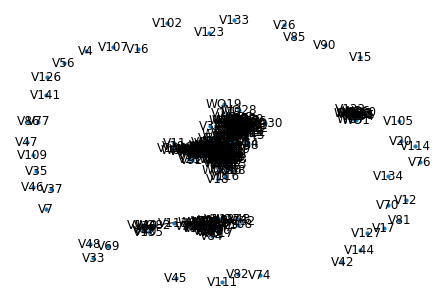

In [105]:
# Draw Graph with nodes and edges with coordinates
G=nx.Graph()
for i,j in vacant_spaces.items():
    G.add_node(i)
G.add_edges_from(nearby_waste100)
nx.draw(G, with_labels=True, node_size=10)

# Create a dictionary with vacant spaces and waste outputs them
new_waste_dict = create_edge_dict(G)
waste_dict = {}
for i,k in new_waste_dict.items():
    if i in vacant_spaces:
            waste_dict[i]=k
    
#List of dictionaries we will use:
# print(v_potential)
# print(waste_dict)
# print(uf_systems)

# add needed inputs for each potential system into the v_potential dictionary
v_potential_dict={}
for i,k in v_potential.items():
    v_potential_dict[i]={}
    potential_systems = v_potential[i]["UF"]
    for item in potential_systems:
       v_potential_dict[i][item] = uf_systems[item]["in"]
        
#Design Rule 1.0 : Waste Availability
    #if there are more than 2 found items assign that system to that vacant space


Design Rule 3.0 : Sharing Existing Resources
    

Prepare Data

In [106]:
# Preparation of Data
#Make a dictionary of found items nearby for each potential uf system
found_dict={}

for i,k in v_potential_dict.items():
    found_dict[i]={}
    for system,demanded in k.items():
        found_dict[i][system]={}
        found_dict[i][system]["found"]={}
        found_dict[i][system]["source"]={}
        found=[]
        source=[]
        for waste in waste_dict[i]:
            for each in demanded: 
                available = wastes[waste]["type"]
                source2 = wastes[waste]["tag"]
                print(i,wastes[waste])
                source_size = wastes[waste]["size"]
                if each == available:
                    found.append(available)
                    source.append(source2)
                    found_dict[i][system]["found"]=found
                    found_dict[i][system]["source"]=source


V0 {'location': '{1956.585915, 340.613461, 0}', 'source': 'fellowship', 'tag': 'WO77', 'type': 'W5', 'node_type': 'waste', 'size': 1}
V0 {'location': '{1956.585915, 340.613461, 0}', 'source': 'fellowship', 'tag': 'WO77', 'type': 'W5', 'node_type': 'waste', 'size': 1}
V0 {'location': '{1956.585915, 340.613461, 0}', 'source': 'fellowship', 'tag': 'WO77', 'type': 'W5', 'node_type': 'waste', 'size': 1}
V0 {'location': '{1890.306386, 340.613461, 0}', 'source': 'fellowship', 'tag': 'WO76', 'type': 'W5', 'node_type': 'waste', 'size': 1}
V0 {'location': '{1890.306386, 340.613461, 0}', 'source': 'fellowship', 'tag': 'WO76', 'type': 'W5', 'node_type': 'waste', 'size': 1}
V0 {'location': '{1890.306386, 340.613461, 0}', 'source': 'fellowship', 'tag': 'WO76', 'type': 'W5', 'node_type': 'waste', 'size': 1}
V0 {'location': '{1893.662311, 299.503374, 0}', 'source': 'AE', 'tag': 'WO79', 'type': 'W3', 'node_type': 'waste', 'size': 3}
V0 {'location': '{1893.662311, 299.503374, 0}', 'source': 'AE', 'tag':

In [107]:

#Make a dictionary of missing for each potential uf system           
for i,system in found_dict.items():
    for uf in system:
        missing=[]
        found_dict[i][uf]["missing"]={}
        for x,y in uf_systems.items():
            for item in uf_systems[x]["in"]:
                if uf == x:
                    missing.append(item)
                    found_dict[i][uf]["missing"]=missing
        
#In the dictionary missing items also contain found items
for i,k in found_dict.items():
    for system in k:
        for item in (found_dict[i][system]["found"]):
            if item in found_dict[i][system]["missing"]:
                missing_list=found_dict[i][system]["missing"]
                missing_list.remove(item)

#reach sizes of duplicate items
for i,k in found_dict.items():
    for system in k:
        found_items=found_dict[i][system]["found"]

#Make a dictionary holding each vacant space& found and repeating waste type & waste sources corresponding to found items
duplicate_items={}
for space,potential in found_dict.items():
    duplicate_items[space]={}
    for system, k in potential.items():
        if len(found_dict[space][system]["found"])> 1:
            found_items3=found_dict[space][system]["found"]
            sources=[]
            for index,items in enumerate(found_items3):
                duplicate_items[space][items]={}
                count=found_items3.count(items)
                if count>1:
                    items_str=str(items)
                    sources.append(found_dict[space][system]["source"][index])
                    duplicate_items[space][items]["matching sources"]=sources

# check if the total size of found waste matches the vacant space size

satisfying_duplicate={}

for space, k in duplicate_items.items():
    satisfying_duplicate[space]={}
    for key,value in k.items():
        satisfying_duplicate[space][key]={}
        waste_matched=[]
        not_matched=[]
        if duplicate_items[space][key]!=[]:
            for m,n in duplicate_items[space][key].items():
                matched=duplicate_items[space][key][m]
                for items in matched:
                    found_new=[]
                    waste_matched.append(wastes[items]["size"])
                    if sum(waste_matched)==vacant_spaces[space]["size"]:
                        # print(space, waste_matched, "add to found list and remove from missing")
                        found_new=matched
                        # print(found_new, "is found")
                    else:
                        # print(sum(waste_matched),"And",vacant_spaces[space]["size"],items)
                        not_matched=items
                        # print(not_matched,"is not matched")
                satisfying_duplicate[space][key]=found_new
                            
print(satisfying_duplicate) 

#remove duplicate items if they are also in satisfying_duplicate items list
for space,potential in found_dict.items():
    for system in potential.keys():
        for key, value in satisfying_duplicate.items():
            for waste in value.keys():
                if key==space:
                        if len(found_dict[space][system]["found"])>0:
                            if len(satisfying_duplicate[key][waste])>0:
                                if waste in found_dict[space][system]["found"]:
                                    type(satisfying_duplicate[key][waste])
                                    found_items = found_dict[space][system]["found"]
                                    duplicate=list_duplicates(found_items)
                                    for found in found_items:
                                        if found in duplicate:
                                            found_items.remove(found)                                                
print(found_dict)
#remove duplicate items if they are not in satisfying_duplicate items list

for space in found_dict.keys():
    for system in found_dict[space].keys():
        found_items = found_dict[space][system]["found"]
        missing_items = found_dict[space][system]["missing"]
        duplicate=list_duplicates(found_items)
        for key, value in satisfying_duplicate.items():
            for waste in value.keys():
                if key==space:
                    for found in found_items:
                        if found in duplicate:
                            print("duplicate",space,found,system)
                            if satisfying_duplicate[space][found]==[]:
                                print("duplicate not satisfying",space,found,system)
                                missing_items.append(found)
                                found_items.remove(found) 

#put not satisfying waste sources in a list
not_enough_waste=[]
for space in found_dict:
    for system in found_dict[space]:
        source=found_dict[space][system]["source"]
        for index in range(len(source)):
            item=source[index]
            waste=wastes[item]["type"]
            if waste in found_dict[space][system]["found"]:
                print("found")
            else:
                not_enough_waste.append(item) 

#remove the items in that list from found dict sources
for space in found_dict:
    for system in found_dict[space]:    
        source=found_dict[space][system]["source"]
        for item in not_enough_waste:
            if item in source:
                source.remove(item)                    #  
            


{'V0': {'W5': []}, 'V1': {'W5': [], 'W6': {}}, 'V2': {'W5': [], 'W6': {}}, 'V3': {'W6': {}, 'W2': {}, 'W3': {}, 'W4': {}, 'W5': []}, 'V4': {}, 'V5': {'W5': [], 'W6': {}}, 'V6': {'W5': [], 'W6': {}}, 'V7': {}, 'V8': {'W5': [], 'W6': [], 'W7': {}}, 'V9': {'W5': []}, 'V10': {'W5': [], 'W6': {}}, 'V11': {}, 'V12': {}, 'V13': {'W6': [], 'W5': []}, 'V14': {'W6': {}, 'W5': []}, 'V15': {}, 'V16': {}, 'V17': {}, 'V18': {}, 'V19': {}, 'V20': {}, 'V21': {}, 'V22': {'W5': [], 'W6': {}}, 'V23': {'W5': ['WO44', 'WO38', 'WO86']}, 'V24': {'W5': [], 'W6': {}}, 'V25': {'W5': []}, 'V26': {}, 'V27': {'W7': {}, 'W5': [], 'W6': {}}, 'V28': {'W5': [], 'W6': {}}, 'V29': {'W5': ['WO52', 'WO50', 'WO60']}, 'V30': {'W5': []}, 'V31': {}, 'V32': {}, 'V33': {}, 'V34': {}, 'V35': {}, 'V36': {}, 'V37': {}, 'V38': {'W5': []}, 'V39': {'W5': ['WO52', 'WO51', 'WO50']}, 'V40': {}, 'V41': {'W5': []}, 'V42': {}, 'V43': {}, 'V44': {'W5': [], 'W6': {}, 'W7': {}}, 'V45': {}, 'V46': {}, 'V47': {}, 'V48': {}, 'V49': {'W5': []}, '

In [108]:
#remove duplicate items in missing list
print(found_dict)
for space in found_dict.keys():
    for system in found_dict[space].keys():
        missing_items2=found_dict[space][system]["missing"]
        print(system,"missing items2 is", missing_items2)
        duplicate=list_duplicates(missing_items2)
        print("duplicate is",duplicate)
        for missing in missing_items2:
            if missing in duplicate:
                missing_items2.remove(missing) 
                print(duplicate)
                # duplicate.remove(missing)
                print(missing,"is removed")
                print(duplicate)
   
# print(found_dict)

{'V0': {'UF4': {'found': ['W5'], 'source': ['WO77', 'WO76'], 'missing': ['W6', 'W7', 'W5']}, 'UF5': {'found': ['W5'], 'source': ['WO77', 'WO76'], 'missing': ['W6', 'W7', 'W5']}, 'UF6': {'found': {}, 'source': {}, 'missing': ['W6']}, 'UF7': {'found': ['W5'], 'source': ['WO77', 'WO76'], 'missing': ['W6', 'W7', 'W5']}, 'UF9': {'found': ['W5'], 'source': ['WO77', 'WO76'], 'missing': ['W6', 'W7', 'W5']}}, 'V1': {'UF4': {'found': ['W6', 'W5'], 'source': [], 'missing': ['W7', 'W5', 'W5', 'W5', 'W5']}, 'UF5': {'found': ['W6', 'W5'], 'source': [], 'missing': ['W7', 'W5', 'W5', 'W5', 'W5']}, 'UF6': {'found': ['W6'], 'source': [], 'missing': []}, 'UF7': {'found': ['W6', 'W5'], 'source': [], 'missing': ['W7', 'W5', 'W5', 'W5', 'W5']}, 'UF9': {'found': ['W6', 'W5'], 'source': [], 'missing': ['W7', 'W5', 'W5', 'W5', 'W5']}}, 'V2': {'UF4': {'found': ['W6', 'W5', 'W5'], 'source': ['WO43', 'WO44', 'WO45', 'WO35', 'WO21', 'WO20'], 'missing': ['W7', 'W5', 'W5', 'W5', 'W5', 'W5', 'W5', 'W5', 'W5']}, 'UF5'

In [109]:
#add circularity percentage to found_dict
for space in found_dict:
    for system in found_dict[space]:
        found_dict[space][system]["circularity"]=[]
        found=len(found_dict[space][system]["found"])
        missing=len(found_dict[space][system]["missing"])
        total=found+missing
        found_dict[space][system]["circularity"]=found/total
print(found_dict)   

#make a duplicate of found dict, sort system based on circularities
sorted_dict={}
for space in found_dict:
    system=sorted(found_dict[space], key=lambda x: (found_dict[space][x]['circularity']), reverse=True)  
    sorted_dict[space]={} 
    for item in system:
        values={}
        values=(found_dict[space][item])
        sorted_dict[space][item]=values

print(sorted_dict)

{'V0': {'UF4': {'found': ['W5'], 'source': ['WO77', 'WO76'], 'missing': ['W6', 'W7', 'W5'], 'circularity': 0.25}, 'UF5': {'found': ['W5'], 'source': ['WO77', 'WO76'], 'missing': ['W6', 'W7', 'W5'], 'circularity': 0.25}, 'UF6': {'found': {}, 'source': {}, 'missing': ['W6'], 'circularity': 0.0}, 'UF7': {'found': ['W5'], 'source': ['WO77', 'WO76'], 'missing': ['W6', 'W7', 'W5'], 'circularity': 0.25}, 'UF9': {'found': ['W5'], 'source': ['WO77', 'WO76'], 'missing': ['W6', 'W7', 'W5'], 'circularity': 0.25}}, 'V1': {'UF4': {'found': ['W6', 'W5'], 'source': [], 'missing': ['W7', 'W5', 'W5'], 'circularity': 0.4}, 'UF5': {'found': ['W6', 'W5'], 'source': [], 'missing': ['W7', 'W5', 'W5'], 'circularity': 0.4}, 'UF6': {'found': ['W6'], 'source': [], 'missing': [], 'circularity': 1.0}, 'UF7': {'found': ['W6', 'W5'], 'source': [], 'missing': ['W7', 'W5', 'W5'], 'circularity': 0.4}, 'UF9': {'found': ['W6', 'W5'], 'source': [], 'missing': ['W7', 'W5', 'W5'], 'circularity': 0.4}}, 'V2': {'UF4': {'found

Assign Food Production System To Vacant Space

In [110]:
#check if the criteria is satisfied
occupied={}
used_waste=[]
used_waste_source=[]
used_waste_source_temp=[]
new_edges=[]
occupied_dict={}

for space in sorted_dict:
    print("looking for", space)
    print("for",space,sorted_dict[space],"is possible")
    occupied_dict[space]={}
    occupied_dict[space]["system"]={}
    occupied_dict[space]["found"]={}
    occupied_dict[space]["source"]={}
    occupied_dict[space]["missing"]={}
    for index,system in enumerate(sorted_dict[space]):
        print("looking for system", system)
        occupied[space]={}
        occupied[space]["system"]={}
        found_list=sorted_dict[space][system]["found"]
        sources_list=sorted_dict[space][system]["source"]
        missing_list=sorted_dict[space][system]["missing"]
        print(len(missing_list),"is length for",space,system)

        if len(occupied[space]["system"])==0:
            print(space,"is not occupied run for",system)
            if len(missing_list)==0:    
                for source in sources_list:
                    if source in used_waste_source:
                        print(used_waste_source,"is used",space,system)
                        pass
                    elif source not in used_waste_source:
                        print(used_waste_source,"is used",space,system)
                        occupied[space]["system"]=system
                        occupied_dict[space]["system"]=system
                        occupied_dict[space]["found"]=sorted_dict[space][system]["found"]
                        occupied_dict[space]["source"]=sorted_dict[space][system]["source"]
                        for items in found_list:
                            used_waste.append(items)
                        used_waste_source.append(source)
                        edge_tuple=(source,space)
                        new_edges.append(edge_tuple)
                        print("no missing items:", space, system, "assign")
                if len(occupied[space]["system"])>0:
                    print(space,system,"will break")        
                    break
        
        if len(occupied[space]["system"])==0:
            if len(missing_list)==1:
                print("one item",system,space)
                for missing in missing_list:
                    if missing in non_critical_items:
                        for source in sources_list:
                            if source not in used_waste_source:
                                print("Used Non Critical Source",source)
                                occupied[space]["system"]=system
                                occupied_dict[space]["system"]=system
                                occupied_dict[space]["found"]=sorted_dict[space][system]["found"]
                                occupied_dict[space]["source"]=sorted_dict[space][system]["source"]
                                occupied_dict[space]["missing"]=sorted_dict[space][system]["missing"]
                                for items in found_list:
                                    used_waste.append(items)
                                used_waste_source.append(source)
                                edge_tuple=(source,space)
                                new_edges.append(edge_tuple)
                                print("one non critical missing items:", space, system, "assign")
                    else:
                        print(space,"critical item missing:",missing,"for",system)
                if len(occupied[space]["system"])>0:
                    print(space,system,"will break")        
                    break

        if occupied[space]["system"]==0 :  
            if len(missing_list)==2:
                for missing in missing_list:
                    if missing in non_critical_items:
                        for source in sources_list:
                            if source not in used_waste_source:
                                print("Used Non Critical Source",source)
                                occupied[space]["system"]=system
                                occupied_dict[space]["system"]=system
                                occupied_dict[space]["found"]=sorted_dict[space][system]["found"]
                                occupied_dict[space]["source"]=sorted_dict[space][system]["source"]
                                occupied_dict[space]["missing"]=sorted_dict[space][system]["missing"]
                                for items in found_list:
                                    used_waste.append(items)
                                print("two non critical missing items:", space, system)
                                used_waste_source.append(source)
                                edge_tuple=(source,space)
                                new_edges.append(edge_tuple)
                    else:
                        print(space,"critical item missing:",missing,"for",system)
                if len(occupied[space]["system"])>0:
                    print(space,system,"will break")        
                    break  

looking for V0
for V0 {'UF4': {'found': ['W5'], 'source': ['WO77', 'WO76'], 'missing': ['W6', 'W7', 'W5'], 'circularity': 0.25}, 'UF5': {'found': ['W5'], 'source': ['WO77', 'WO76'], 'missing': ['W6', 'W7', 'W5'], 'circularity': 0.25}, 'UF7': {'found': ['W5'], 'source': ['WO77', 'WO76'], 'missing': ['W6', 'W7', 'W5'], 'circularity': 0.25}, 'UF9': {'found': ['W5'], 'source': ['WO77', 'WO76'], 'missing': ['W6', 'W7', 'W5'], 'circularity': 0.25}, 'UF6': {'found': {}, 'source': {}, 'missing': ['W6'], 'circularity': 0.0}} is possible
looking for system UF4
3 is length for V0 UF4
V0 is not occupied run for UF4
looking for system UF5
3 is length for V0 UF5
V0 is not occupied run for UF5
looking for system UF7
3 is length for V0 UF7
V0 is not occupied run for UF7
looking for system UF9
3 is length for V0 UF9
V0 is not occupied run for UF9
looking for system UF6
1 is length for V0 UF6
V0 is not occupied run for UF6
one item UF6 V0
looking for V1
for V1 {'UF6': {'found': ['W6'], 'source': [], 'mi

Create New List To Be Used In Next Steps

In [111]:
print(occupied)  
print(used_waste_source) 
print(new_edges)
print(occupied_dict)
#add circularity & outputs to occupied_dict
for space in occupied_dict:
    occupied_dict[space]["circularity"]={}
    occupied_dict[space]["outputs"]={}
    occupied_dict[space]["supplements"]={}
    if len(occupied_dict[space]["system"])!=0:
        system=occupied_dict[space]["system"]
        outputs=(uf_systems[system]["out"])
        supplements=uf_systems[system]["supplement"]
        occupied_dict[space]["circularity"]=found_dict[space][system]["circularity"]
        occupied_dict[space]["supplements"]=supplements
        occupied_dict[space]["outputs"]=outputs

#remove empty spaces from occupied_dict
remove=[]
for space in occupied_dict:
    if len(occupied_dict[space]["system"])==0:
        remove.append(space)
for items in remove:
    occupied_dict.pop(items)
print("occupied",occupied_dict)

#remove assigned spaces from found_dict
remove2=[]
for space in sorted_dict:
    if space in occupied_dict:
        remove2.append(space)
for items in remove2:
    sorted_dict.pop(items)
print("non occupied",sorted_dict)

{'V0': {'system': {}}, 'V1': {'system': {}}, 'V2': {'system': {}}, 'V3': {'system': 'UF3'}, 'V4': {'system': {}}, 'V5': {'system': {}}, 'V6': {'system': {}}, 'V7': {'system': {}}, 'V8': {'system': {}}, 'V9': {'system': {}}, 'V10': {'system': {}}, 'V11': {'system': {}}, 'V12': {'system': {}}, 'V13': {'system': {}}, 'V14': {'system': {}}, 'V15': {'system': {}}, 'V16': {'system': {}}, 'V17': {'system': {}}, 'V18': {'system': {}}, 'V19': {'system': {}}, 'V20': {'system': {}}, 'V21': {'system': {}}, 'V22': {'system': {}}, 'V23': {'system': {}}, 'V24': {'system': {}}, 'V25': {'system': {}}, 'V26': {'system': {}}, 'V27': {'system': {}}, 'V28': {'system': {}}, 'V29': {'system': {}}, 'V30': {'system': {}}, 'V31': {'system': {}}, 'V32': {'system': {}}, 'V33': {'system': {}}, 'V34': {'system': {}}, 'V35': {'system': {}}, 'V36': {'system': {}}, 'V37': {'system': {}}, 'V38': {'system': {}}, 'V39': {'system': {}}, 'V40': {'system': {}}, 'V41': {'system': {}}, 'V42': {'system': {}}, 'V43': {'system':

6. Assign Food Producing Supplementary Systems

Prepare Data

In [112]:
#look for a system that can supply needed supplement
#put the findings in a dictionary
v_supplement_fs={}
for space in occupied_dict:
    v_supplement_fs[space]={}
    v_supplement_fs[space]["supplement"]={}
    v_supplement_fs[space]["fs_system"]={}
    v_supplement_fs[space]["supplement"]={}
    v_supplement_fs[space]["supplement source"]={}
    v_supplement_fs[space]["fs_demand"]={}
    v_supplement_fs[space]["fs_demand source"]={}
    v_supplement_fs[space]["potential source"]={}
    supplement=occupied_dict[space]["supplements"]
    if supplement!=None:
        for item in supplement:
            if item=="S2": 
                for i in uf_systems:
                    out=uf_systems[i]["out"]
                    if "S2" in out:
                        print("maybe",space, i,uf_systems[i]["in"])
                        v_supplement_fs[space]["fs_system"]=i
                        v_supplement_fs[space]["supplement"]=item
                        v_supplement_fs[space]["fs_demand"]=uf_systems[i]["in"]
    else:
        v_supplement_fs[space]["fs_system"]={}

print(v_supplement_fs)


maybe V97 UF2 ['W7']
maybe V98 UF2 ['W7']
maybe V113 UF2 ['W7']
{'V3': {'supplement': {}, 'fs_system': {}, 'supplement source': {}, 'fs_demand': {}, 'fs_demand source': {}, 'potential source': {}}, 'V97': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': ['W7'], 'fs_demand source': {}, 'potential source': {}}, 'V98': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': ['W7'], 'fs_demand source': {}, 'potential source': {}}, 'V113': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': ['W7'], 'fs_demand source': {}, 'potential source': {}}}


In [113]:
#created a dictionary for spaces which need supplement to store system, supplementing neighbor and supplement type
#for each space found what kind of system and supplement and input is necessary 

#look neighbors of supplement needing space to see if there is a potential neighbor
for space in v_supplement_fs:
    potential=[]
    for space2,neighbor in nearby_space100:
        if space==space2:
            if (len(v_supplement_fs[space]["supplement source"])==0) and (len(v_supplement_fs[space]["fs_system"])!=0):
                # print(neighbor,"is available")
                system=v_supplement_fs[space]["fs_system"]
                print(system,"system")
                print(vacant_spaces[space]["size"],vacant_spaces[neighbor]["size"])
                if (vacant_spaces[space]["size"]==vacant_spaces[neighbor]["size"]) and (vacant_spaces[neighbor]["structure"]>=uf_systems[system]["weight"]) and (vacant_spaces[neighbor]["solar"]>=uf_systems[system]["solar"]):
                    potential.append(neighbor)
                    # print(space,potential)
                    v_supplement_fs[space]["potential source"]=potential
        elif space==neighbor:
                print(neighbor,space2,"reverse is available")
                if (len(v_supplement_fs[space]["supplement source"])==0) and (len(v_supplement_fs[space]["fs_system"])!=0):
                    print(space2,"is available")
                    system=v_supplement_fs[space]["fs_system"]
                    if (vacant_spaces[space]["size"]==vacant_spaces[space2]["size"]) and (vacant_spaces[space2]["structure"]>=uf_systems[system]["weight"]) and (vacant_spaces[space2]["solar"]>=uf_systems[system]["solar"]):
                        potential.append(space2)
                        print(potential)
                        print(space,potential)
                        print(space,"matches",space2,"and",system)
                        v_supplement_fs[space]["potential source"]=potential
                    else:
                        print("structure",space,vacant_spaces[space2]["structure"],system,uf_systems[system]["weight"])
                        print("sun",space,vacant_spaces[space2]["solar"],system,uf_systems[system]["solar"])
                else:
                    print(space,space2,"not available",v_supplement_fs[space]["fs_system"],"no need for supplement")
# print(v_supplement_fs)


V97 V10 reverse is available
V10 is available
structure V97 3 UF2 3
sun V97 3 UF2 2
V97 V17 reverse is available
V17 is available
structure V97 3 UF2 3
sun V97 3 UF2 2
V97 V18 reverse is available
V18 is available
structure V97 3 UF2 3
sun V97 3 UF2 2
V97 V65 reverse is available
V65 is available
structure V97 3 UF2 3
sun V97 3 UF2 2
V97 V71 reverse is available
V71 is available
structure V97 1 UF2 3
sun V97 3 UF2 2
V97 V73 reverse is available
V73 is available
structure V97 3 UF2 3
sun V97 3 UF2 2
V97 V96 reverse is available
V96 is available
['V96']
V97 ['V96']
V97 matches V96 and UF2
UF2 system
2 2
UF2 system
2 2
UF2 system
2 2
V98 V25 reverse is available
V25 is available
structure V98 1 UF2 3
sun V98 3 UF2 2
V98 V27 reverse is available
V27 is available
structure V98 1 UF2 3
sun V98 3 UF2 2
V98 V53 reverse is available
V53 is available
structure V98 3 UF2 3
sun V98 3 UF2 2
V98 V71 reverse is available
V71 is available
structure V98 1 UF2 3
sun V98 3 UF2 2
V98 V73 reverse is availa

In [114]:
#check if potential sources have fs_demand
for space in v_supplement_fs:
    potential=v_supplement_fs[space]["potential source"]
    if len(v_supplement_fs[space]["supplement source"])==0:
        # print(vacant,len(v_supplement_fs[space]["supplement source"]),"---",v_supplement_fs[space]["supplement source"])
        for vacant in potential:
            nearby_list=waste_dict[vacant]
            for nearby in nearby_list:
                print(vacant, nearby,"is",wastes[nearby]["type"])
                if nearby not in used_waste_source:
                    if wastes[nearby]["size"]==vacant_spaces[space]["size"]:
                        print(nearby,"not used")
                        if v_supplement_fs[space]["fs_demand"]==wastes[nearby]["type"]:
                            print("for",space,vacant,"is potential and has",nearby,"as a source of",wastes[nearby]["type"])
                            v_supplement_fs[space]["supplement source"]=vacant
                            print(v_supplement_fs[space]["supplement source"])
                            v_supplement_fs[space]["fs_demand source"]=nearby
                            print(v_supplement_fs[space]["fs_demand source"])
                            used_waste_source.append(nearby)
                            edge_tuple1=(nearby,vacant)
                            edge_tuple2=(vacant,space)
                            new_edges.append(edge_tuple1)
                            new_edges.append(edge_tuple2)
                            if len(v_supplement_fs[space]["supplement source"])>0:
                                # print(space,system,"will break")        
                                break

            if len(v_supplement_fs[space]["supplement source"])>0:
                            # print(space,system,"will break2")        
                            break
                    
# print(v_supplement_fs)  
# print(used_waste_source) 
# print(new_edges)     
print("occupied",occupied_dict)

for space in v_supplement_fs:
    if len(v_supplement_fs[space]["fs_system"])!=0:
        if len(v_supplement_fs[space]["supplement source"])!=0:
            occ=v_supplement_fs[space]["supplement source"]
            occupied_dict[occ]={}
            occupied_dict[occ]["found"]=v_supplement_fs[space]["fs_demand"]
            occupied_dict[occ]["system"]=v_supplement_fs[space]["fs_system"]
            system=occupied_dict[occ]["system"]
            occupied_dict[occ]["source"]=v_supplement_fs[space]["fs_demand source"]
            occupied_dict[occ]["supplements"]=uf_systems[system]["supplement"]
print(occupied_dict)

#make a dictionary of source: waste type: size: receiver:tuple
network_dict={}
for source,space in new_edges:
    type_list=[]
    network_dict[source]={}
    network_dict[source]["type"]={}
    network_dict[source]["size"]={}
    network_dict[source]["receiver"]={}

for source,space in new_edges:
    network_dict[source]["receiver"]=space
    if source in wastes:
        network_dict[source]["type"]=wastes[source]["type"]
        network_dict[source]["size"]=wastes[source]["size"]
    elif source in vacant_spaces:
        network_dict[source]["size"]=vacant_spaces[source]["size"]
        network_dict[source]["type"]=occupied_dict[source]["found"]
    
print(network_dict)
print(occupied_dict)
for space in v_supplement_fs:
    if len(v_supplement_fs[space]["fs_system"])!=0:
        print("work")
        if len(v_supplement_fs[space]["supplement source"])!=0:
            occ=v_supplement_fs[space]["supplement source"]
            occupied_dict[occ]={}
            print(occupied_dict)
            occupied_dict[occ]["found"]=v_supplement_fs[space]["fs_demand"]
            occupied_dict[occ]["system"]=v_supplement_fs[space]["fs_system"]
            occupied_dict[occ]["source"]=v_supplement_fs[space]["fs_demand source"]
print(occupied_dict)

#make a dictionary of source: waste type: size: receiver:tuple
network_dict={}
for source,space in new_edges:
    type_list=[]
    network_dict[source]={}
    network_dict[source]["type"]={}
    network_dict[source]["size"]={}
    network_dict[source]["receiver"]={}

for source,space in new_edges:
    network_dict[source]["receiver"]=space
    if source in wastes:
        network_dict[source]["type"]=wastes[source]["type"]
        network_dict[source]["size"]=wastes[source]["size"]
    elif source in vacant_spaces:
        network_dict[source]["size"]=vacant_spaces[source]["size"]
        network_dict[source]["type"]=occupied_dict[source]["found"]

print(network_dict)

#now we have food supplying supplementary systems
#we still need to check if these systems need supplements
for space in occupied_dict: 
    system=occupied_dict[space]["system"]
    # print(system)
    # print(uf_systems[system]["supplement"])
    value=uf_systems[system]["supplement"]
    if value!=None:
        for supplement in value:
            if (supplement=="S5") or (supplement=="S4"):
                v_supplement_fs[space]={}
                v_supplement_fs[space]["supplement"]=supplement
                for uf in uf_systems:
                    for out in uf_systems[uf]["out"]:
                        if supplement == out:
                            v_supplement_fs[space]["fs_system"]=uf
                            v_supplement_fs[space]["fs_demand"]=uf_systems[uf]["in"]
                v_supplement_fs[space]["supplement source"]={}
                v_supplement_fs[space]["fs_demand source"]={}
                v_supplement_fs[space]["potential source"]={}
    print(v_supplement_fs)


V96 WO73 is W4
V96 WO62 is W5
V120 WO72 is W1
V120 WO62 is W5
V120 WO60 is W5
V120 WO65 is W4
WO65 not used
V120 WO63 is W5
V120 WO64 is W5
V116 WO68 is W5
V116 WO72 is W1
V119 WO0 is W7
V119 WO56 is W5
V119 WO54 is W1
V119 WO27 is W5
V124 WO27 is W5
V124 WO0 is W7
V124 WO54 is W1
V124 WO24 is W5
V124 WO55 is W5
V124 WO18 is W5
V124 WO67 is W6
V124 WO48 is W4
occupied {'V3': {'system': 'UF3', 'found': ['W6', 'W2', 'W3', 'W4'], 'source': ['WO42', 'WO1', 'WO3', 'WO4'], 'missing': {}, 'circularity': 1.0, 'outputs': ['O3', 'S4'], 'supplements': None}, 'V97': {'system': 'UF4', 'found': ['W5', 'W6'], 'source': ['WO68'], 'missing': ['W7'], 'circularity': 0.6666666666666666, 'outputs': ['O1', 'W1'], 'supplements': ['S2']}, 'V98': {'system': 'UF4', 'found': ['W7', 'W6'], 'source': ['WO0'], 'missing': ['W5'], 'circularity': 0.6666666666666666, 'outputs': ['O1', 'W1'], 'supplements': ['S2']}, 'V113': {'system': 'UF4', 'found': ['W7', 'W5'], 'source': ['WO82', 'WO80'], 'missing': ['W6'], 'circular

In [115]:
#make a potential list
for space in v_supplement_fs:
    potential=[]
    print(space)
    for space2,neighbor in nearby_space100:  
        if (space==space2):
            print(space2,neighbor)
            if (len(v_supplement_fs[space]["supplement source"])==0) and (len(v_supplement_fs[space]["fs_system"])!=0):
                print(neighbor,"is available")
                system=v_supplement_fs[space]["fs_system"]
                if (vacant_spaces[space]["size"]==vacant_spaces[neighbor]["size"]) and (vacant_spaces[neighbor]["structure"]>=uf_systems[system]["weight"]) and (vacant_spaces[neighbor]["solar"]>=uf_systems[system]["solar"]):
                    potential.append(neighbor)
                    print(potential)
                    print(space,potential)
                    v_supplement_fs[space]["potential source"]=potential
                else:
                    print(space,vacant_spaces[neighbor]["structure"],system,uf_systems[system]["weight"])
            else:
                print(space,neighbor,"not available",v_supplement_fs[space]["fs_system"],"no need for supplement")
        elif space==neighbor:
            print(neighbor,space2,"reverse is available")
            if (len(v_supplement_fs[space]["supplement source"])==0) and (len(v_supplement_fs[space]["fs_system"])!=0):
                print(space2,"is available")
                system=v_supplement_fs[space]["fs_system"]
                if (vacant_spaces[space]["size"]==vacant_spaces[space2]["size"]) and (vacant_spaces[space2]["structure"]>=uf_systems[system]["weight"]) and (vacant_spaces[space2]["solar"]>=uf_systems[system]["solar"]):
                    potential.append(space2)
                    print(potential)
                    print(space,potential)
                    print(space,"matches",space2,"and",system)
                    v_supplement_fs[space]["potential source"]=potential
                else:
                    print("structure",space,vacant_spaces[space2]["structure"],system,uf_systems[system]["weight"])
                    print("sun",space,vacant_spaces[space2]["solar"],system,uf_systems[system]["solar"])
                    print("size",vacant_spaces[space]["size"]==vacant_spaces[space2]["size"])
            else:
                print(space,space2,"not available",v_supplement_fs[space]["fs_system"],"no need for supplement")
print(v_supplement_fs)


V3
V3 V68
V3 V68 not available {} no need for supplement
V3 V100
V3 V100 not available {} no need for supplement
V3 V6
V3 V6 not available {} no need for supplement
V3 V122
V3 V122 not available {} no need for supplement
V3 V129
V3 V129 not available {} no need for supplement
V97
V97 V10 reverse is available
V10 is available
structure V97 3 UF2 3
sun V97 3 UF2 2
size False
V97 V17 reverse is available
V17 is available
structure V97 3 UF2 3
sun V97 3 UF2 2
size False
V97 V18 reverse is available
V18 is available
structure V97 3 UF2 3
sun V97 3 UF2 2
size False
V97 V65 reverse is available
V65 is available
structure V97 3 UF2 3
sun V97 3 UF2 2
size False
V97 V71 reverse is available
V71 is available
structure V97 1 UF2 3
sun V97 3 UF2 2
size False
V97 V73 reverse is available
V73 is available
structure V97 3 UF2 3
sun V97 3 UF2 2
size False
V97 V96 reverse is available
V96 is available
['V96']
V97 ['V96']
V97 matches V96 and UF2
V97 V131
V131 is available
V97 1 UF2 3
V97 V120
V120 is ava

In [116]:
#check if potential sources have fs_demand
print(used_waste_source)
for space in v_supplement_fs:
    potential=v_supplement_fs[space]["potential source"]
    if len(v_supplement_fs[space]["supplement source"])==0:
        for vacant in potential:
            found=[]
            found_source=[]
            nearby_list=waste_dict[vacant]
            for nearby in nearby_list:
                print(vacant, nearby,"is",wastes[nearby]["type"])
                if nearby not in used_waste_source:
                    if wastes[nearby]["size"]==vacant_spaces[space]["size"]:
                        print(nearby,"not used")
                        found.append(wastes[nearby]["type"])
                        found_source.append(nearby)
                        print(found)
                        if v_supplement_fs[space]["fs_demand"]==found:
                            print("for",space,vacant,"is potential and has",nearby,"as a source of",wastes[nearby]["type"])
                            v_supplement_fs[space]["supplement source"]=vacant
                            print(v_supplement_fs[space]["supplement source"])
                            v_supplement_fs[space]["fs_demand source"]=found_source
                            print(v_supplement_fs[space]["fs_demand source"])
                            for x in found_source:
                                used_waste_source.append(x)
                                edge_tuple1=(x,vacant)
                                new_edges.append(edge_tuple1)
                            edge_tuple2=(vacant,space)
                            new_edges.append(edge_tuple2)
                            print("new edges added",new_edges)
                            if len(v_supplement_fs[space]["supplement source"])>0:
                                # print(space,system,"will break")        
                                break

            if len(v_supplement_fs[space]["supplement source"])>0:
                            # print(space,system,"will break2")        
                            break
                    
print(v_supplement_fs) 
# print(new_edges)
# print(used_waste_source)

['WO42', 'WO1', 'WO3', 'WO4', 'WO68', 'WO0', 'WO82', 'WO80']
V96 WO73 is W4
V96 WO62 is W5
V120 WO72 is W1
V120 WO62 is W5
V120 WO60 is W5
V120 WO65 is W4
WO65 not used
['W4']
V120 WO63 is W5
V120 WO64 is W5
V116 WO68 is W5
V116 WO72 is W1
V119 WO0 is W7
V119 WO56 is W5
V119 WO54 is W1
V119 WO27 is W5
V124 WO27 is W5
V124 WO0 is W7
V124 WO54 is W1
V124 WO24 is W5
V124 WO55 is W5
V124 WO18 is W5
V124 WO67 is W6
V124 WO48 is W4
{'V3': {'supplement': {}, 'fs_system': {}, 'supplement source': {}, 'fs_demand': {}, 'fs_demand source': {}, 'potential source': {}}, 'V97': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': ['W7'], 'fs_demand source': {}, 'potential source': ['V96', 'V120', 'V116']}, 'V98': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': ['W7'], 'fs_demand source': {}, 'potential source': ['V119', 'V124']}, 'V113': {'supplement': 'S2', 'fs_system': 'UF2', 'supplement source': {}, 'fs_demand': ['W7'], 'fs_demand source': 

In [117]:
print(occupied_dict)
for space in v_supplement_fs:
    if len(v_supplement_fs[space]["fs_system"])!=0:
        if len(v_supplement_fs[space]["supplement source"])!=0:
            occ=v_supplement_fs[space]["supplement source"]
            occupied_dict[occ]={}
            occupied_dict[occ]["found"]=v_supplement_fs[space]["fs_demand"]
            occupied_dict[occ]["system"]=v_supplement_fs[space]["fs_system"]
            system=v_supplement_fs[space]["fs_system"]
            print(occ,system)
            print(len(uf_systems[system]))
            print(len(occupied_dict[occ]["found"]))
            occupied_dict[occ]["source"]=v_supplement_fs[space]["fs_demand source"]
            occupied_dict[occ]["outputs"]=v_supplement_fs[space]["supplement"]
            occupied_dict[occ]["supplements"]=uf_systems[system]["supplement"]
            occupied_dict[occ]["circularity"]=1.0
print(occupied_dict)



{'V3': {'system': 'UF3', 'found': ['W6', 'W2', 'W3', 'W4'], 'source': ['WO42', 'WO1', 'WO3', 'WO4'], 'missing': {}, 'circularity': 1.0, 'outputs': ['O3', 'S4'], 'supplements': None}, 'V97': {'system': 'UF4', 'found': ['W5', 'W6'], 'source': ['WO68'], 'missing': ['W7'], 'circularity': 0.6666666666666666, 'outputs': ['O1', 'W1'], 'supplements': ['S2']}, 'V98': {'system': 'UF4', 'found': ['W7', 'W6'], 'source': ['WO0'], 'missing': ['W5'], 'circularity': 0.6666666666666666, 'outputs': ['O1', 'W1'], 'supplements': ['S2']}, 'V113': {'system': 'UF4', 'found': ['W7', 'W5'], 'source': ['WO82', 'WO80'], 'missing': ['W6'], 'circularity': 0.6666666666666666, 'outputs': ['O1', 'W1'], 'supplements': ['S2']}}
{'V3': {'system': 'UF3', 'found': ['W6', 'W2', 'W3', 'W4'], 'source': ['WO42', 'WO1', 'WO3', 'WO4'], 'missing': {}, 'circularity': 1.0, 'outputs': ['O3', 'S4'], 'supplements': None}, 'V97': {'system': 'UF4', 'found': ['W5', 'W6'], 'source': ['WO68'], 'missing': ['W7'], 'circularity': 0.666666666

In [118]:
#make a dictionary of source: waste type: size: receiver:tuple
network_dict={}
for source,space in new_edges:
    type_list=[]
    network_dict[source]={}
    network_dict[source]["type"]={}
    network_dict[source]["size"]={}
    network_dict[source]["receiver"]={}

for source,space in new_edges:
    network_dict[source]["receiver"]=space
    if source in wastes:
        network_dict[source]["type"]=wastes[source]["type"]
        network_dict[source]["size"]=wastes[source]["size"]
    elif source in vacant_spaces:
        network_dict[source]["size"]=vacant_spaces[source]["size"]
        network_dict[source]["type"]=occupied_dict[source]["outputs"]
    
# print(network_dict)

for space in occupied_dict:
    if occupied_dict[space]["system"]==None:
        occupied_dict.remove(space)
print(new_edges)
print(network_dict)

[('WO42', 'V3'), ('WO1', 'V3'), ('WO3', 'V3'), ('WO4', 'V3'), ('WO68', 'V97'), ('WO0', 'V98'), ('WO82', 'V113'), ('WO80', 'V113')]
{'WO42': {'type': 'W6', 'size': 3, 'receiver': 'V3'}, 'WO1': {'type': 'W2', 'size': 3, 'receiver': 'V3'}, 'WO3': {'type': 'W3', 'size': 3, 'receiver': 'V3'}, 'WO4': {'type': 'W4', 'size': 2, 'receiver': 'V3'}, 'WO68': {'type': 'W5', 'size': 1, 'receiver': 'V97'}, 'WO0': {'type': 'W7', 'size': 2, 'receiver': 'V98'}, 'WO82': {'type': 'W7', 'size': 3, 'receiver': 'V113'}, 'WO80': {'type': 'W5', 'size': 1, 'receiver': 'V113'}}


In [119]:
for space in occupied_dict:
    print(space,occupied_dict[space]["system"])

V3 UF3
V97 UF4
V98 UF4
V113 UF4


Increasing Search Radius(nearby_waste200)
#make a dictionary of spaces and potential urban farming systems 


In [120]:
#combine wastes and vacant_spaces
workbook = load_workbook(filename="coordintes_xyz.xlsx")
workbook.sheetnames
sheet1 = workbook.worksheets[0]
sheet2 = workbook.worksheets[1]

new_edges2=[]
for space in network_dict:
    sources=(network_dict[space]["receiver"])
    tuples=(space,sources)
    new_edges2.append(tuples)
print(new_edges2)

[('WO42', 'V3'), ('WO1', 'V3'), ('WO3', 'V3'), ('WO4', 'V3'), ('WO68', 'V97'), ('WO0', 'V98'), ('WO82', 'V113'), ('WO80', 'V113')]


In [121]:
#update locations in dictionary based on excel worksheet
coordinate_list1=[]
for value in sheet1.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
            coordinate=(value[0],value[1],value[2])
    coordinate_list1.append(coordinate)

for index1,space in enumerate(vacant_spaces):
    for index2,coordinate in enumerate(coordinate_list1):
        if index1==index2:
            vacant_spaces[space]["location"]=coordinate_list1[index2]


#update locations in dictionary based on excel worksheet

workbook = load_workbook(filename="Node_Information_TU.xlsx")
workbook.sheetnames
sheet1 = workbook.worksheets[0]
sheet2 = workbook.worksheets[1]
wastes2={}
for value in sheet2.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
        wastes2[value[0]]={}
        wastes2[value[0]]["location"]=value[1]
        wastes2[value[0]]["source"]=value[2]
        wastes2[value[0]]["type"]=value[3]
        wastes2[value[0]]["quantity"]=value[4]
        wastes2[value[0]]["tag"]=value[5]
        wastes2[value[0]]["node_type"]="waste"


In [122]:
#update locations in dictionary based on excel worksheet

workbook = load_workbook(filename="coordintes_xyz.xlsx")
workbook.sheetnames
sheet1 = workbook.worksheets[0]
sheet2 = workbook.worksheets[1]

coordinate_list2=[]
for value in sheet2.iter_rows(min_row=2, values_only=True):
    for index,item in enumerate(value):
            coordinate=(value[0],value[1],value[2])
    coordinate_list2.append(coordinate)

for index1,space in enumerate(wastes2):
    for index2,coordinate in enumerate(coordinate_list2): 
        if index1==index2:
            # print(index2,coordinate,space)
            wastes2[space]["location"]=coordinate_list2[index2]

combined_dict=vacant_spaces.copy()
combined_dict.update(wastes2)

coordinates=[]
#make a coordinate list for new_edges [(coordinates1,coordinates2),(coordinates1,coordinates2),(coordinates1,coordinates2)]
for item in new_edges2:
        # print(item)
        coordinate_tuple=(combined_dict[item[0]]["location"],combined_dict[item[1]]["location"])
        print(item,coordinate_tuple)
        coordinates.append(coordinate_tuple)

print(coordinates,"is coordinates")
print(new_edges2)


('WO42', 'V3') ((246.741859, 572.172323, 0), (254.491041, 556.132177, 0))
('WO1', 'V3') ((274.847735, 547.422372, 0), (254.491041, 556.132177, 0))
('WO3', 'V3') ((284.076531, 481.981824, 0), (254.491041, 556.132177, 0))
('WO4', 'V3') ((190.949597, 634.676436, 0), (254.491041, 556.132177, 0))
('WO68', 'V97') ((1225.413641, 700.955965, 0), (1273.333716, 711.489837, 0))
('WO0', 'V98') ((940.159971, 709.345779, 0), (986.590205, 767.909158, 0))
('WO82', 'V113') ((2254.004814, 255.456851, 0), (2118.089831, 203.440173, 0))
('WO80', 'V113') ((1922.187678, 234.062826, 0), (2118.089831, 203.440173, 0))
[((246.741859, 572.172323, 0), (254.491041, 556.132177, 0)), ((274.847735, 547.422372, 0), (254.491041, 556.132177, 0)), ((284.076531, 481.981824, 0), (254.491041, 556.132177, 0)), ((190.949597, 634.676436, 0), (254.491041, 556.132177, 0)), ((1225.413641, 700.955965, 0), (1273.333716, 711.489837, 0)), ((940.159971, 709.345779, 0), (986.590205, 767.909158, 0)), ((2254.004814, 255.456851, 0), (2118.

In [123]:
export_edges_dict={}
for index,couple in enumerate(coordinates):
        export_edges_dict[index]={}
        export_edges_dict[index]["coordinate"]=couple

export_edges_dict={}
for index,waste in enumerate(network_dict):
        export_edges_dict[index]={}
        export_edges_dict[index]["type"]=network_dict[waste]["type"]
        export_edges_dict[index]["connection"]=coordinates[index]

print(export_edges_dict)

{0: {'type': 'W6', 'connection': ((246.741859, 572.172323, 0), (254.491041, 556.132177, 0))}, 1: {'type': 'W2', 'connection': ((274.847735, 547.422372, 0), (254.491041, 556.132177, 0))}, 2: {'type': 'W3', 'connection': ((284.076531, 481.981824, 0), (254.491041, 556.132177, 0))}, 3: {'type': 'W4', 'connection': ((190.949597, 634.676436, 0), (254.491041, 556.132177, 0))}, 4: {'type': 'W5', 'connection': ((1225.413641, 700.955965, 0), (1273.333716, 711.489837, 0))}, 5: {'type': 'W7', 'connection': ((940.159971, 709.345779, 0), (986.590205, 767.909158, 0))}, 6: {'type': 'W7', 'connection': ((2254.004814, 255.456851, 0), (2118.089831, 203.440173, 0))}, 7: {'type': 'W5', 'connection': ((1922.187678, 234.062826, 0), (2118.089831, 203.440173, 0))}}


In [124]:
#Make a dictionary of all spaces and systems
export_dict={}
for space in vacant_spaces:
    export_dict[space]={}
    export_dict[space]["location"]={}
    export_dict[space]["system"]={}
for space in vacant_spaces:
    if space in occupied_dict:
        export_dict[space]["system"]=occupied_dict[space]["system"]
        export_dict[space]["location"]=combined_dict[space]["location"]
    else:
        export_dict[space]["system"]=None
        export_dict[space]["location"]=None
print(export_dict)

{'V0': {'location': None, 'system': None}, 'V1': {'location': None, 'system': None}, 'V2': {'location': None, 'system': None}, 'V3': {'location': (254.491041, 556.132177, 0), 'system': 'UF3'}, 'V4': {'location': None, 'system': None}, 'V5': {'location': None, 'system': None}, 'V6': {'location': None, 'system': None}, 'V7': {'location': None, 'system': None}, 'V8': {'location': None, 'system': None}, 'V9': {'location': None, 'system': None}, 'V10': {'location': None, 'system': None}, 'V11': {'location': None, 'system': None}, 'V12': {'location': None, 'system': None}, 'V13': {'location': None, 'system': None}, 'V14': {'location': None, 'system': None}, 'V15': {'location': None, 'system': None}, 'V16': {'location': None, 'system': None}, 'V17': {'location': None, 'system': None}, 'V18': {'location': None, 'system': None}, 'V19': {'location': None, 'system': None}, 'V20': {'location': None, 'system': None}, 'V21': {'location': None, 'system': None}, 'V22': {'location': None, 'system': Non

In [125]:
file = "occupied nodes2.txt"
with open(str(file), 'w') as outfile:
    try:
        json.dump(export_dict, outfile)
        print(file + " has been updated successfully")
    except:
        print("Problem with updating file")

file = "new_edges2.txt"
with open(str(file), 'w') as outfile:
    try:
        json.dump(new_edges, outfile)
        print(file + " has been updated successfully")
    except:
        print("Problem with updating file")

file = "new_edges_dict2.txt"
with open(str(file), 'w') as outfile:
    try:
        json.dump(export_edges_dict, outfile)
        print(file + " has been updated successfully")
    except:
        print("Problem with updating file")        

file = "coordinates2.txt"
with open(str(file), 'w') as outfile:
    try:
        json.dump(coordinates, outfile)
        print(file + " has been updated successfully")
    except:
        print("Problem with updating file")

occupied nodes2.txt has been updated successfully
new_edges2.txt has been updated successfully
new_edges_dict2.txt has been updated successfully
coordinates2.txt has been updated successfully


8. INCREASING RADIUS